开始加载模型结果...
已加载: Gate_Dense (0.0%) - 8 benchmarks
已加载: Gate_Sparse (50.6%) - 8 benchmarks
已加载: Gate_Sparse (81.3%) - 8 benchmarks
已加载: Gate_Sparse (91.0%) - 8 benchmarks
已加载: UP_Sparse (58.1%) - 8 benchmarks
已加载: UP_Sparse (90.1%) - 8 benchmarks
已加载: UP_Sparse (96.0%) - 8 benchmarks

模型性能对比预览:
       Benchmark  Gate_Dense (0.0%)  Gate_Sparse (50.6%)  Gate_Sparse (81.3%)  \
0  arc_challenge             0.5666               0.5904               0.5247   
1       arc_easy             0.8413               0.8384               0.7879   
2          boolq             0.8526               0.8456               0.7783   
3      hellaswag             0.6488               0.6674               0.6263   
4     openbookqa             0.3480               0.3620               0.3260   
5           piqa             0.8248               0.8264               0.7965   
6           sciq             0.9680               0.9700               0.9180   
7     winogrande             0.7640               0.7522 

AttributeError: module 'matplotlib' has no attribute 'patheffects'

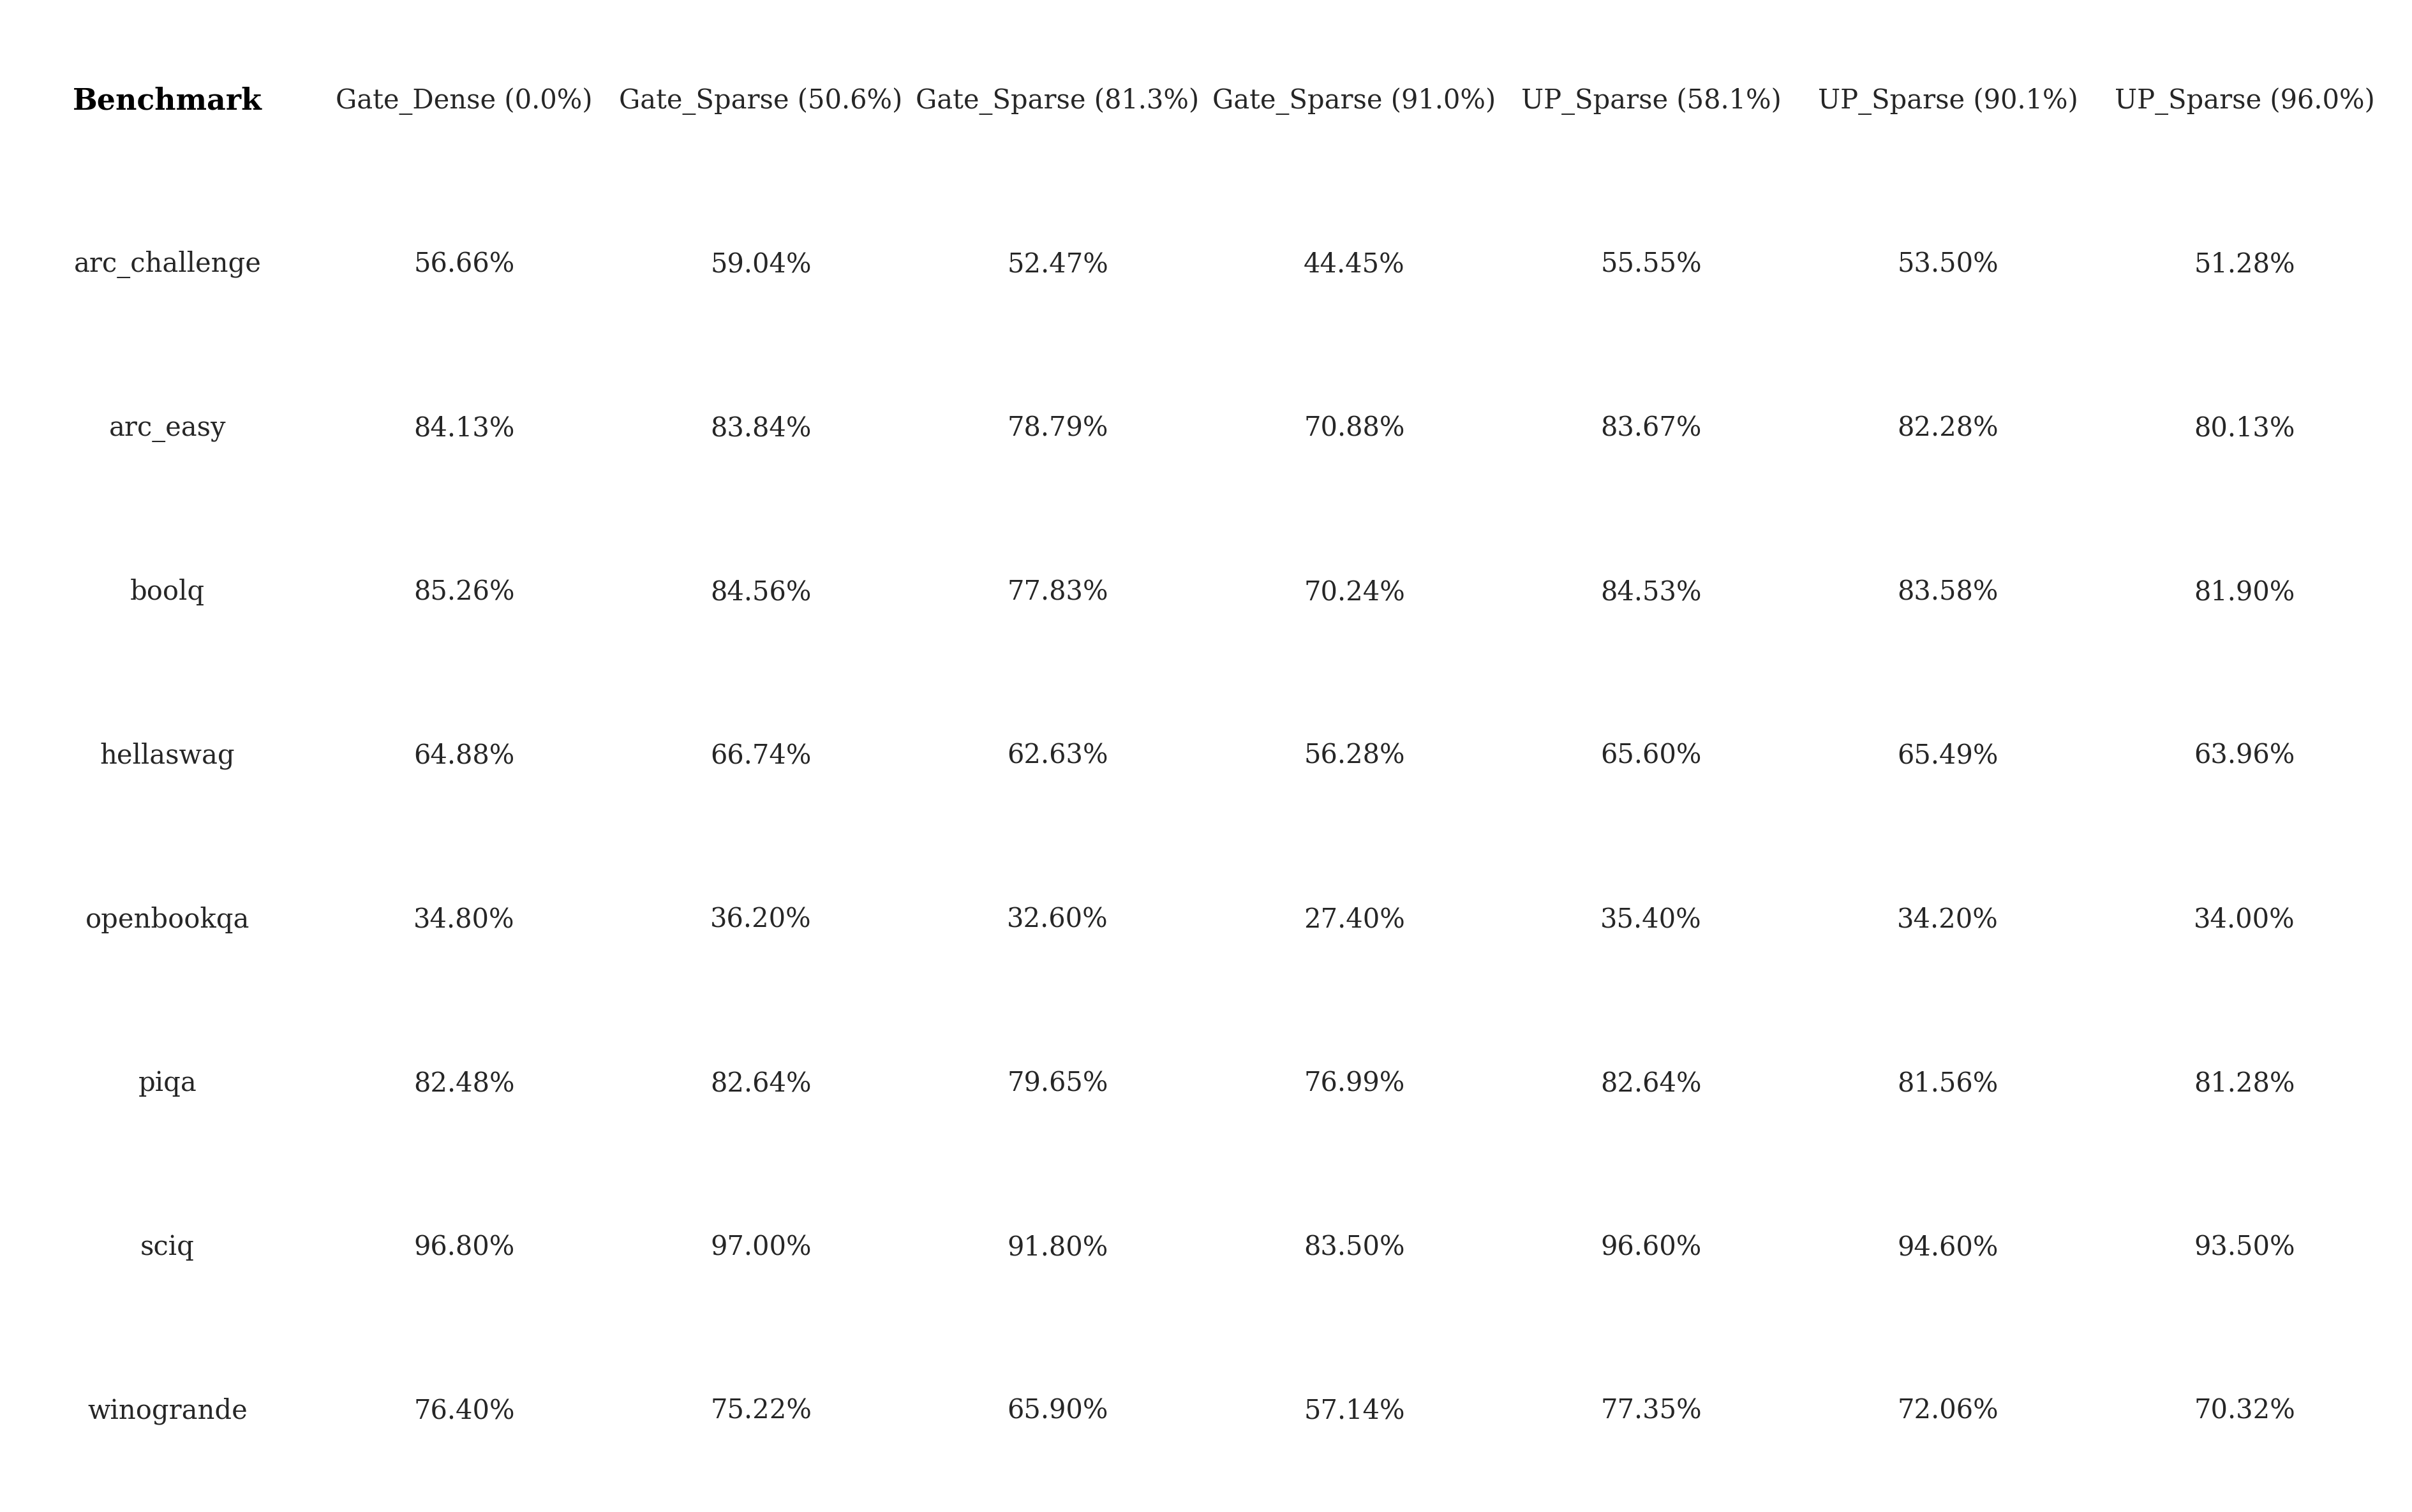

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import numpy as np
import os

def extract_model_name(file_path):
    """从文件路径中提取模型名称，使用实际稀疏度"""
    # 实际稀疏度映射
    sparsity_mapping = {
        'sparse_0p_0steps2':    0.0,
        'sparse_50p_0steps2':   0.5062,
        'sparse_80p_0steps2':   0.8130,
        'sparse_90p_0steps2':   0.9099,
    }
    
    # UP版本的稀疏度
    up_sparsity_mapping = {
        'sparse_50p_0steps2': 0.5810,
        'sparse_80p_0steps2': 0.9015,
        'sparse_90p_0steps2': 0.9605
    }
    
    # 确定前缀和稀疏度
    if 't_res_up_sparse' in file_path:
        prefix = "UP_"
        mapping = up_sparsity_mapping
    else:
        prefix = "Gate_"
        mapping = sparsity_mapping
    
    # 查找匹配的稀疏度配置
    for config, actual_sparsity in mapping.items():
        if config in file_path:
            if config == 'sparse_0p_0steps2':
                return f"{prefix}Dense ({actual_sparsity:.1%})"
            else:
                return f"{prefix}Sparse ({actual_sparsity:.1%})"
    
    # 如果没有匹配到，返回默认名称
    return os.path.basename(os.path.dirname(file_path))

def load_results_from_files(file_paths):
    """从多个JSON文件中加载结果"""
    all_results = {}
    
    for file_path in file_paths:
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                model_name = extract_model_name(file_path)
                
                # 提取每个benchmark的acc,none值
                results = data.get('results', {})
                model_results = {}
                
                for benchmark_name, benchmark_results in results.items():
                    acc_none = benchmark_results.get('acc,none', None)
                    if acc_none is not None:
                        model_results[benchmark_name] = acc_none
                
                all_results[model_name] = model_results
                print(f"已加载: {model_name} - {len(model_results)} benchmarks")
                
        except Exception as e:
            print(f"加载文件 {file_path} 时出错: {e}")
    
    return all_results

def create_comparison_dataframe(all_results):
    """创建对比数据框"""
    # 获取所有benchmark名称
    all_benchmarks = set()
    for model_results in all_results.values():
        all_benchmarks.update(model_results.keys())
    
    all_benchmarks = sorted(list(all_benchmarks))
    
    # 创建数据框
    df_data = []
    for benchmark in all_benchmarks:
        row = {'Benchmark': benchmark}
        for model_name, model_results in all_results.items():
            row[model_name] = model_results.get(benchmark, np.nan)
        df_data.append(row)
    
    df = pd.DataFrame(df_data)
    return df

def get_scientific_colors():
    """获取科研绘图标准配色方案"""
    # 科研绘图标准配色（色盲友好）
    colors = {
        'primary': '#1f77b4',      # 蓝色
        'secondary': '#ff7f0e',    # 橙色
        'success': '#2ca02c',      # 绿色
        'danger': '#d62728',       # 红色
        'warning': '#ff9896',      # 浅红色
        'info': '#17becf',         # 青色
        'purple': '#9467bd',       # 紫色
        'brown': '#8c564b',        # 棕色
        'pink': '#e377c2',         # 粉色
        'gray': '#7f7f7f',         # 灰色
        'olive': '#bcbd22',        # 橄榄色
        'cyan': '#17becf'          # 青蓝色
    }
    
    # 表格颜色
    table_colors = {
        'header': '#34495e',       # 深蓝灰色表头
        'best': '#d5f4e6',         # 浅绿色（最佳性能）
        'worst': '#fadbd8',        # 浅红色（最差性能）
        'alt_row': '#f8f9fa',      # 浅灰色交替行
        'border': '#bdc3c7'        # 边框灰色
    }
    
    # 热力图颜色
    heatmap_colors = 'RdYlBu_r'    # 红-黄-蓝反转（科研标准）
    
    return colors, table_colors, heatmap_colors

def create_comparison_pdf(df, output_filename='model_comparison_results.pdf'):
    """创建包含对比结果的PDF文件"""
    # 设置科研绘图风格
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif']
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.linewidth'] = 1.2
    plt.rcParams['grid.alpha'] = 0.3
    plt.rcParams['figure.dpi'] = 300
    
    # 获取科研配色
    colors, table_colors, heatmap_cmap = get_scientific_colors()
    
    # 创建科研标准配色列表
    scientific_palette = [
        colors['primary'], colors['secondary'], colors['success'], 
        colors['danger'], colors['purple'], colors['brown'], 
        colors['pink'], colors['gray'], colors['olive']
    ]
    
    model_columns = [col for col in df.columns if col != 'Benchmark']
    
    with PdfPages(output_filename) as pdf:
        # 第一页：完整对比表格
        fig, ax = plt.subplots(figsize=(16, 10))
        ax.axis('tight')
        ax.axis('off')
        
        # 准备表格数据（转换为百分比）
        table_data = df.copy()
        for col in model_columns:
            table_data[col] = table_data[col].apply(lambda x: f"{x*100:.2f}%" if not pd.isna(x) else "N/A")
        
        # 创建表格
        table = ax.table(cellText=table_data.values,
                        colLabels=table_data.columns,
                        cellLoc='center',
                        loc='center',
                        bbox=[0, 0, 1, 1])
        
        # 设置表格样式
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.8)
        
        # 设置表头样式（科研标准深色）
        for i in range(len(table_data.columns)):
            table[(0, i)].set_facecolor(table_colors['header'])
            table[(0, i)].set_text_props(weight='bold', color='white')
            table[(0, i)].set_edgecolor(table_colors['border'])
        
        # 设置行的交替颜色和性能标记
        for i in range(1, len(table_data) + 1):
            for j in range(len(table_data.columns)):
                cell = table[(i, j)]
                cell.set_edgecolor(table_colors['border'])
                cell.set_linewidth(0.5)
                
                if i % 2 == 0:
                    cell.set_facecolor(table_colors['alt_row'])
                else:
                    cell.set_facecolor('white')
                
                # 为数值列添加颜色编码（最高值绿色，最低值红色）
                if j > 0:  # 跳过Benchmark列
                    try:
                        value = df.iloc[i-1, j]
                        if not pd.isna(value):
                            row_values = df.iloc[i-1, 1:].dropna()
                            if len(row_values) > 1:
                                max_val = row_values.max()
                                min_val = row_values.min()
                                if value == max_val:
                                    cell.set_facecolor(table_colors['best'])
                                elif value == min_val:
                                    cell.set_facecolor(table_colors['worst'])
                    except:
                        pass
        
        plt.title('Sparse Mixtral 7×8B Models: Benchmark Performance Comparison\n(Green: Best Performance, Red: Worst Performance)', 
                 fontsize=14, fontweight='bold', pad=20, family='serif')
        
        pdf.savefig(fig, bbox_inches='tight', dpi=300)
        plt.close()
        
        # 第二页：性能对比热力图
        fig, ax = plt.subplots(figsize=(14, 10))
        
        # 准备热力图数据
        heatmap_data = df.set_index('Benchmark')[model_columns]
        
        # 创建科研标准热力图
        sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap=heatmap_cmap, 
                   cbar_kws={'label': 'Accuracy', 'shrink': 0.8}, ax=ax, 
                   linewidths=0.5, linecolor='white', square=False,
                   annot_kws={'size': 8, 'weight': 'normal'})
        
        plt.title('Model Performance Heatmap\n(Higher Values Indicate Better Performance)', 
                 fontsize=14, fontweight='bold', pad=20, family='serif')
        plt.xlabel('Model Configurations', fontsize=12, family='serif')
        plt.ylabel('Benchmark Tasks', fontsize=12, family='serif')
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight', dpi=300)
        plt.close()
        
        # 第三页：每个benchmark的柱状图对比
        fig, axes = plt.subplots(3, 3, figsize=(18, 15))
        axes = axes.flatten()
        
        benchmarks = df['Benchmark'].tolist()
        
        for idx, benchmark in enumerate(benchmarks[:9]):
            if idx < len(axes):
                ax = axes[idx]
                
                # 获取该benchmark的数据
                benchmark_data = df[df['Benchmark'] == benchmark][model_columns].iloc[0]
                valid_data = benchmark_data.dropna()
                
                if len(valid_data) > 0:
                    bars = ax.bar(range(len(valid_data)), valid_data.values, 
                                 color=scientific_palette[:len(valid_data)],
                                 edgecolor='black', linewidth=0.8, alpha=0.8)
                    
                    ax.set_title(f'{benchmark}', fontsize=11, fontweight='bold', family='serif')
                    ax.set_xticks(range(len(valid_data)))
                    ax.set_xticklabels(valid_data.index, rotation=45, ha='right', fontsize=8)
                    ax.set_ylabel('Accuracy', fontsize=9, family='serif')
                    ax.grid(True, alpha=0.3, axis='y')
                    ax.set_axisbelow(True)
                    
                    # 在柱子上显示数值
                    for bar, value in zip(bars, valid_data.values):
                        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                               f'{value:.3f}', ha='center', va='bottom', fontsize=7, weight='bold')
        
        # 隐藏多余的子图
        for idx in range(len(benchmarks), len(axes)):
            axes[idx].set_visible(False)
        
        plt.suptitle('Individual Benchmark Performance Comparison', 
                    fontsize=16, fontweight='bold', family='serif')
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight', dpi=300)
        plt.close()
        
        # 第四页：统计分析
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. 平均性能对比
        avg_performance = df[model_columns].mean()
        bars1 = ax1.bar(range(len(avg_performance)), avg_performance.values, 
                       color=scientific_palette[:len(avg_performance)],
                       edgecolor='black', linewidth=0.8, alpha=0.8)
        ax1.set_title('Average Performance Across All Benchmarks', fontweight='bold', family='serif')
        ax1.set_xticks(range(len(avg_performance)))
        ax1.set_xticklabels(avg_performance.index, rotation=45, ha='right')
        ax1.set_ylabel('Average Accuracy', family='serif')
        ax1.grid(True, alpha=0.3, axis='y')
        ax1.set_axisbelow(True)
        
        for bar, value in zip(bars1, avg_performance.values):
            ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        # 2. 性能标准差
        std_performance = df[model_columns].std()
        bars2 = ax2.bar(range(len(std_performance)), std_performance.values,
                       color=scientific_palette[:len(std_performance)],
                       edgecolor='black', linewidth=0.8, alpha=0.8)
        ax2.set_title('Performance Standard Deviation', fontweight='bold', family='serif')
        ax2.set_xticks(range(len(std_performance)))
        ax2.set_xticklabels(std_performance.index, rotation=45, ha='right')
        ax2.set_ylabel('Standard Deviation', family='serif')
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.set_axisbelow(True)
        
        # 3. 最佳性能计数
        best_count = {}
        for col in model_columns:
            best_count[col] = 0
        
        for idx, row in df.iterrows():
            row_values = row[model_columns].dropna()
            if len(row_values) > 0:
                best_model = row_values.idxmax()
                best_count[best_model] += 1
        
        bars3 = ax3.bar(range(len(best_count)), list(best_count.values()),
                       color=scientific_palette[:len(best_count)],
                       edgecolor='black', linewidth=0.8, alpha=0.8)
        ax3.set_title('Number of Best Performances by Model', fontweight='bold', family='serif')
        ax3.set_xticks(range(len(best_count)))
        ax3.set_xticklabels(list(best_count.keys()), rotation=45, ha='right')
        ax3.set_ylabel('Count of Best Performances', family='serif')
        ax3.grid(True, alpha=0.3, axis='y')
        ax3.set_axisbelow(True)
        
        for bar, value in zip(bars3, best_count.values()):
            ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                    str(value), ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        # 4. 性能分布箱线图
        plot_data = []
        plot_labels = []
        for col in model_columns:
            valid_values = df[col].dropna()
            if len(valid_values) > 0:
                plot_data.append(valid_values)
                plot_labels.append(col)
        
        if plot_data:
            box_plot = ax4.boxplot(plot_data, labels=plot_labels, patch_artist=True,
                                  boxprops=dict(linewidth=1.2),
                                  whiskerprops=dict(linewidth=1.2),
                                  capprops=dict(linewidth=1.2),
                                  medianprops=dict(linewidth=1.5, color='black'))
            ax4.set_title('Performance Distribution', fontweight='bold', family='serif')
            ax4.set_ylabel('Accuracy', family='serif')
            ax4.grid(True, alpha=0.3, axis='y')
            ax4.set_axisbelow(True)
            ax4.tick_params(axis='x', rotation=45)
            
            # 为箱线图添加科研标准颜色
            for patch, color in zip(box_plot['boxes'], scientific_palette[:len(plot_data)]):
                patch.set_facecolor(color)
                patch.set_alpha(0.7)
                patch.set_edgecolor('black')
        
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight', dpi=300)
        plt.close()
        
        # 第五页：详细统计报告
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.axis('off')
        
        # 生成统计报告文本
        report_text = "Sparse Mixtral 7×8B Models: Detailed Performance Analysis\n"
        report_text += "=" * 70 + "\n\n"
        
        report_text += f"Total Models Compared: {len(model_columns)}\n"
        report_text += f"Total Benchmarks Evaluated: {len(df)}\n\n"
        
        report_text += "Model Performance Summary:\n"
        report_text += "-" * 35 + "\n"
        
        for model in model_columns:
            valid_scores = df[model].dropna()
            if len(valid_scores) > 0:
                avg_score = valid_scores.mean()
                std_score = valid_scores.std()
                min_score = valid_scores.min()
                max_score = valid_scores.max()
                best_benchmarks = sum(1 for idx, row in df.iterrows() 
                                    if not pd.isna(row[model]) and row[model] == row[model_columns].max())
                
                report_text += f"\n{model}:\n"
                report_text += f"  • Average Accuracy: {avg_score:.4f} ({avg_score*100:.2f}%)\n"
                report_text += f"  • Standard Deviation: {std_score:.4f}\n"
                report_text += f"  • Performance Range: {min_score:.4f} - {max_score:.4f}\n"
                report_text += f"  • Best Performance Count: {best_benchmarks}\n"
        
        report_text += "\n\nBenchmark-wise Best Performers:\n"
        report_text += "-" * 40 + "\n"
        
        for idx, row in df.iterrows():
            benchmark = row['Benchmark']
            row_values = row[model_columns].dropna()
            if len(row_values) > 0:
                best_model = row_values.idxmax()
                best_score = row_values.max()
                report_text += f"{benchmark:15}: {best_model} ({best_score:.4f})\n"
        
        ax.text(0.05, 0.95, report_text, transform=ax.transAxes, fontsize=9,
               verticalalignment='top', fontfamily='monospace', 
               bbox=dict(boxstyle="round,pad=0.5", facecolor='#f8f9fa', alpha=0.8))
        
        pdf.savefig(fig, bbox_inches='tight', dpi=300)
        plt.close()

def main():
    # 定义文件路径列表
    file_paths = [
        '/home/fit/renju/WORK/lxm/CATS/t_res/evaluations/sparse_mixtral_7x8b_sparse_0p_0steps2/results.json',
        '/home/fit/renju/WORK/lxm/CATS/t_res/evaluations/sparse_mixtral_7x8b_sparse_50p_0steps2/results.json',
        '/home/fit/renju/WORK/lxm/CATS/t_res/evaluations/sparse_mixtral_7x8b_sparse_80p_0steps2/results.json',
        '/home/fit/renju/WORK/lxm/CATS/t_res/evaluations/sparse_mixtral_7x8b_sparse_90p_0steps2/results.json',
        '/home/fit/renju/WORK/lxm/CATS/t_res_up_sparse/evaluations/sparse_mixtral_7x8b_sparse_50p_0steps2/results.json',
        '/home/fit/renju/WORK/lxm/CATS/t_res_up_sparse/evaluations/sparse_mixtral_7x8b_sparse_80p_0steps2/results.json',
        '/home/fit/renju/WORK/lxm/CATS/t_res_up_sparse/evaluations/sparse_mixtral_7x8b_sparse_90p_0steps2/results.json'
    ]
    
    print("开始加载模型结果...")
    
    # 加载所有结果
    all_results = load_results_from_files(file_paths)
    
    if not all_results:
        print("没有成功加载任何结果文件！")
        return
    
    # 创建对比数据框
    df = create_comparison_dataframe(all_results)
    
    # 显示控制台预览
    print("\n模型性能对比预览:")
    print("=" * 80)
    print(df.round(4))
    
    # 创建PDF报告
    pdf_filename = 'sparse_mixtral_models_comparison_scientific.pdf'
    create_comparison_pdf(df, pdf_filename)
    print(f"\nPDF对比报告已生成: {pdf_filename}")
    
    # 保存CSV文件
    csv_filename = 'sparse_mixtral_comparison_results.csv'
    df.to_csv(csv_filename, index=False)
    print(f"CSV文件已保存: {csv_filename}")
    
    # 显示简要统计
    model_columns = [col for col in df.columns if col != 'Benchmark']
    print(f"\n简要统计:")
    print(f"对比模型数: {len(model_columns)}")
    print(f"测试基准数: {len(df)}")
    
    avg_scores = df[model_columns].mean()
    print(f"\n各模型平均性能:")
    for model, score in avg_scores.items():
        print(f"  {model}: {score:.4f} ({score*100:.2f}%)")

if __name__ == "__main__":
    main()

I can see you're getting an error related to `matplotlib.patheffects`. This is because you're trying to access `patheffects` as an attribute of the main `matplotlib` module, but it needs to be imported separately. Here's how to fix this: The error occurs because `matplotlib.patheffects` needs to be imported separately. You're trying to access it as `plt.matplotlib.patheffects`, but it should be imported directly.

Here's how to fix the import issue:



Add this import statement at the top of your cell with the other imports:




In [ ]:
import matplotlib.patheffects as path_effects

 replace this line in your code:



In [ ]:
header_cell.set_path_effects([
    plt.matplotlib.patheffects.withStroke(linewidth=3, foreground='black')
])




With:



In [ ]:
header_cell.set_path_effects([
    path_effects.withStroke(linewidth=3, foreground='black')
])




However, looking at your code more carefully, it seems like you're trying to add visual effects to table cells. The `patheffects` module is typically used for text effects, not table cell borders. For creating proper three-line tables (which is what you seem to be aiming for), you should remove that problematic code section entirely and rely on the manual line drawing you're already doing with `ax.axhline()`.

Here's the corrected import section for your notebook:




In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects  # Add this line
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import numpy as np
import os




Or, if you don't actually need path effects for your table formatting, you can simply remove the problematic `set_path_effects` code block entirely, as your three-line table is already being created properly with the `ax.axhline()` calls.